### NLP-DOTA 2

In [ ]:
## import packages

In [17]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from collections import Counter

In [18]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [19]:
import spacy
from spacy import displacy

import nltk
from nltk.corpus import wordnet as wn
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import hdbscan
import umap

from transformers import T5ForConditionalGeneration,T5Tokenizer
from transformers import BertModel, BertConfig, BertPreTrainedModel, BertTokenizer
from sentence_transformers import SentenceTransformer, util
from transformers import TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import torch
import tensorflow as tf
from tabulate import tabulate
from torch.nn.functional import softmax

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dayan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [1]:
from dask import delayed
from dask.distributed import Client

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100

### Dask Client

In [3]:
client = Client(n_workers=8)

client

Client Scheduler: tcp://127.0.0.1:59182 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 8.00 GiB


### Data Input: Metacritic Reviews for Dota 2

In [20]:
df = pd.read_csv('MetacriticReviews_DOTA2.csv')

In [21]:
reviews = df['review'].to_list()

In [ ]:
# document = nlp(reviews[4])
# document.ents
# displacy.render(document, style="ent")

In [ ]:
## spacy models

In [9]:
nlp = spacy.load('en_core_web_sm')
nlp_2 = spacy.load('en_core_web_lg')

In [ ]:
## HF-transformers

In [15]:
model_mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

embeddings_mpnet = model_mpnet.encode(reviews,show_progress_bar=True)

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

In [16]:
model_dstill = SentenceTransformer('distilbert-base-nli-mean-tokens')

embeddings_dstill = model_dstill.encode(reviews,show_progress_bar=True)



    
    

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

In [23]:
umap_embeddings_1 = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings_mpnet)

umap_embeddings_2 = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings_dstill)


In [24]:

cluster_1 = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings_1)

cluster_2 = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings_2)

In [25]:
## VADER sentiment analyser

sid = SentimentIntensityAnalyzer()

## Define important functions

#### Class based TF-IDF

In [26]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
#tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [27]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    
    return top_n_words


In [28]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [ ]:
##

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
    return train_InputExamples, validation_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )
        
        def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


In [ ]:
DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

## Topic Modelling 

In [29]:
docs_df = pd.DataFrame(reviews, columns=["Doc"])
docs_df['Topic'] = cluster_1.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [30]:
docs_df_2 = pd.DataFrame(reviews, columns=["Doc"])
docs_df_2['Topic'] = cluster_2.labels_
docs_df_2['Doc_ID'] = range(len(docs_df))
docs_per_topic_2 = docs_df_2.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [31]:
tf_idf_1, count_1 = c_tf_idf(docs_per_topic.Doc.values, m=len(reviews))

tf_idf_2, count_2 = c_tf_idf(docs_per_topic_2.Doc.values, m=len(reviews))

In [35]:
top_n_words_1 = extract_top_n_words_per_topic(tf_idf_1, count_1, docs_per_topic, n=20)

In [36]:
top_n_words_1

{-1: [('hats', 0.025624276446511843),
  ('valve', 0.02265842762112638),
  ('got', 0.021260349253270947),
  ('dota', 0.020080328316072003),
  ('community', 0.019556202107251217),
  ('event', 0.018939125582812317),
  ('just', 0.018799344640577274),
  ('bad', 0.018495774347705083),
  ('diretidegive', 0.018339006068664867),
  ('new', 0.016364635411228946),
  ('play', 0.015676220955680935),
  ('heroes', 0.015160504586013665),
  ('thanks', 0.015113238191668349),
  ('mad', 0.014915866313551246),
  ('don', 0.014196417688165184),
  ('good', 0.01414559609989693),
  ('2013', 0.013412968813505642),
  ('people', 0.01326834673107396),
  ('10', 0.013199882279799822),
  ('want', 0.013096638947969327)],
 0: [('fuvolvo', 1.0585996653557315),
  ('diretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidediretidedireti

In [37]:

topic_sizes_1 = extract_topic_sizes(docs_df); topic_sizes_1.head(10)

,Topic,Size
0,-1,721
14,13,231
19,18,85
17,16,83
29,28,67
13,12,63
24,23,61
10,9,54
31,30,53
25,24,46


In [44]:
top_n_words_2 = extract_top_n_words_per_topic(tf_idf_2, count_2, docs_per_topic_2, n=20)

In [48]:

topic_sizes_2 = extract_topic_sizes(docs_df_2); topic_sizes_2.head(10)

,Topic,Size
1,0,1680
0,-1,70
7,6,40
5,4,33
3,2,31
6,5,25
2,1,20
4,3,17
9,8,16
8,7,15


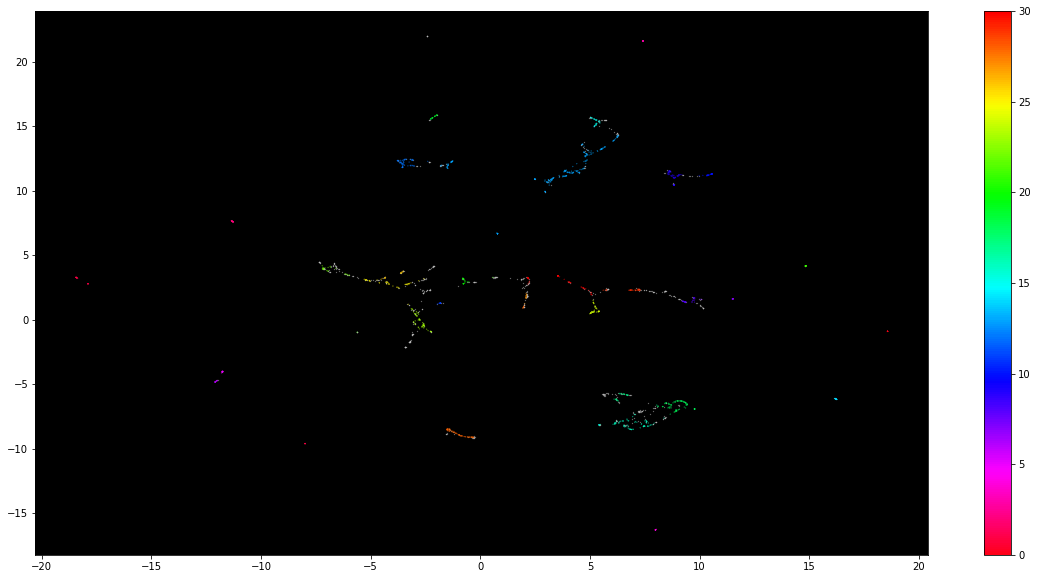

In [42]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(umap_embeddings_1)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_1.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
ax.set_facecolor('xkcd:black')

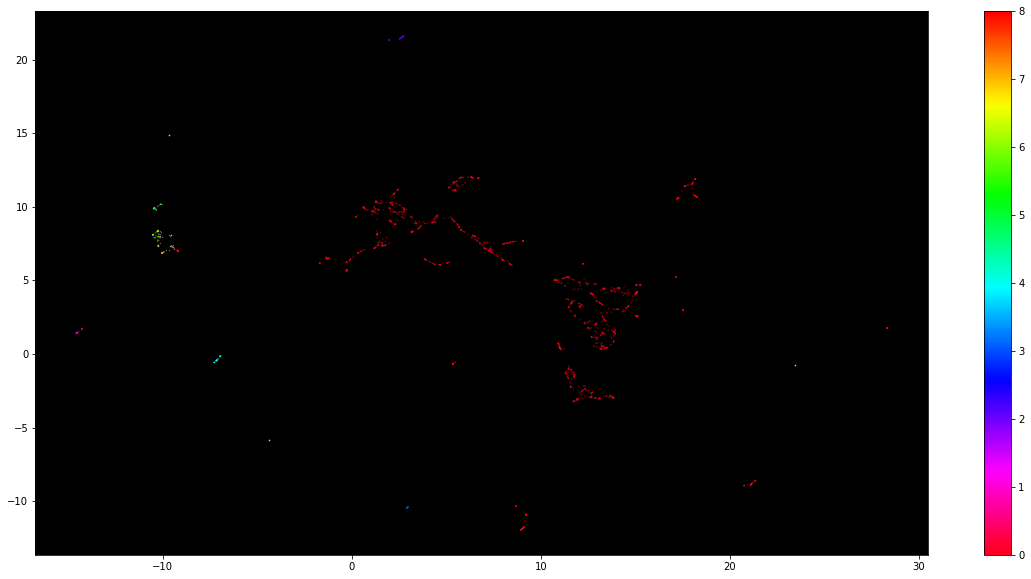

In [43]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(umap_embeddings_2)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_2.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
ax.set_facecolor('xkcd:black')

### Paraphrasing with BERT

In [46]:
paraphrases = util.paraphrase_mining(model_mpnet, reviews)

for paraphrase in paraphrases[0:10]:
    score, i, j = paraphrase
    print("{} \t\t {} \t\t Score: {:.4f}".format(reviews[i], reviews[j], score))

DiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretide 		 fdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfd 		 Score: 1.0000
DiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretideDiretide 		 DiretideDiretideDiretideDiretideDiretideDire

In [ ]:
## fuck

## Sentiment Analysis with Vader

#### BERT model we will optimise later

In [ ]:
model_tf= TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer_tf = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
model_tf.summary()

In [ ]:
df['scores'] = df['review'].apply(lambda review: sid.polarity_scores(review))

#### clean and explore dataframe

In [ ]:
ls = []

for index, row in df.iterrows():
    if row['rating'] >=5:
        hum_lab = 'POS'
    else:
        hum_lab = 'NEG'
        
    ls.append(hum_lab)

In [ ]:
df['human_labels'] = ls

In [ ]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df.head()

In [ ]:
df = df.iloc[: , 1:]

In [ ]:
df = df.iloc[: , 1:]

In [ ]:
df

In [ ]:
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

df.head()

In [ ]:
### check the distribution

In [ ]:
check_comp = df['compound'].to_list()

In [ ]:
std_dev = statistics.stdev(check_comp)

In [ ]:
mean = np.mean(check_comp)

In [ ]:
snd = norm(mean,std_dev)

In [ ]:
plt.figure(figsize=(7.5,7.5))
plt.plot(x, snd.pdf(x))
plt.xlim(-60, 60)
plt.title('Normal Distribution (Mean = {}, STD = {})'.format(mean,std_dev), fontsize='15')
plt.xlabel('Values of Random Variable X', fontsize='15')
plt.ylabel('Probability', fontsize='15')
plt.show()

In [ ]:
x = np.linspace(-1000000000, 10000, 100000000)

In [ ]:
df.rename(columns={'comp_score':'vader_score'}, inplace=True)

In [ ]:
ls2 = []

for index, row in df.iterrows():
    if row['vader_score'] == 'pos':
        sk_label_vader = 1
        ls2.append(sk_label_vader)
    else:
        sk_label_vader = 0
        ls2.append(sk_label_vader)

df['sk_vader_score'] = ls2
        
        

In [ ]:
ls3 = []

for index, row in df.iterrows():
    if row['human_labels'] == 'POS':
        sk_label = 1
        ls3.append(sk_label_vader)
    else:
        sk_label = 0
        ls3.append(sk_label)

df['sk_human_score'] = ls3
        
        

In [ ]:
df

In [ ]:
## test on vader first

In [ ]:
X = df['review']

y  = df['sk_vader_score']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.8)

In [ ]:
X_train

In [ ]:
test = pd.DataFrame(zip(X_train,y_train))

In [ ]:
train = pd.DataFrame(zip(X_test,y_test))

In [ ]:
train.columns = ["DATA_COLUMN","LABEL_COLUMN"]

In [ ]:
test.columns = ["DATA_COLUMN","LABEL_COLUMN"]

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)

train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

#### Fine tune with BERT

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

In [ ]:
pred_sentences = ["Definitely best MOBA out there. Game is very complicated and difficult to learn for those who have never played similar games before, but in my opinion complexity is not a flaw. Due to frequent updates Dota 2 never gets repetitive and manages to adapt without changing its core aspects.","Boring Game. Bad servers. The game keeps disconnecting. Players are rude.  when I was going to play my first match I discovered that the community is really unsupportive not beginner-friendly"]

In [ ]:
### test the fine-tuned model

In [ ]:
test_this = test['DATA_COLUMN'].to_list()


tf_batch = tokenizer(test_this, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()


In [ ]:
for i in range(len(test_this)):
      print(test_this[i], ": \n", labels[label[i]])        